In [43]:
import pandas as pd
import numpy as np
import itertools
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
df=pd.read_json("Team12_Chevron.json")

In [8]:
df.head(5)

,text,sentiment
1,Good morning. My name is Jonathan and I will b...,neutral
10,"Thanks Mike. Turning to Slide 5, an overview o...",neutral
100,"And so, there are times when we can fall in lo...",negative
101,Our next question comes from the line of Sam M...,neutral
102,"Mike, I'm going to try to not ask you to say t...",neutral


In [10]:
df['sentiment'].value_counts()

neutral     54
positive    45
negative    29
Name: sentiment, dtype: int64

In [11]:
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 102
Test size: 26


In [12]:
train_posts = df['text'][:train_size]
train_tags = df['sentiment'][:train_size]

test_posts = df['text'][train_size:]
test_tags = df['sentiment'][train_size:]

In [15]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [16]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [19]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [24]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [25]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (102, 1000)
x_test shape: (26, 1000)
y_train shape: (102, 3)
y_test shape: (26, 3)


In [26]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [30]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 91 samples, validate on 11 samples
Epoch 1/2
91/91 [==============================] - 0s 3ms/step - loss: 1.1105 - acc: 0.4615 - val_loss: 1.1106 - val_acc: 0.4545
Epoch 2/2
91/91 [==============================] - 0s 363us/step - loss: 0.8521 - acc: 0.6923 - val_loss: 1.0956 - val_acc: 0.4545


In [32]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

26/26 [==============================] - 0s 77us/step
Test score: 1.0748307704925537
Test accuracy: 0.38461539149284363


In [39]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

You mentioned that you've done about 150,000 acres ...
Actual label:negative
Predicted label: positive

Yes, so, we will share lot more detail in March be ...
Actual label:neutral
Predicted label: positive

And so, with our 2.2 million net acres and 1.7 mil ...
Actual label:positive
Predicted label: positive

Our currently disclosed resource, there is 1.2 bil ...
Actual label:positive
Predicted label: positive

Earlier this week, we announced a $0.07 per share  ...
Actual label:positive
Predicted label: positive

We are returns-driven and I mentioned that in my p ...
Actual label:neutral
Predicted label: positive

And as you go through that kind of growth, you str ...
Actual label:positive
Predicted label: positive

So, our Jay will talk a lot more about this in Mar ...
Actual label:neutral
Predicted label: positive

Thanks Mike. And we know also that you have got an ...
Actual label:positive
Predicted label: positive

Yes, so we were committed to capital discipline. W ...
Actual label

In [40]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

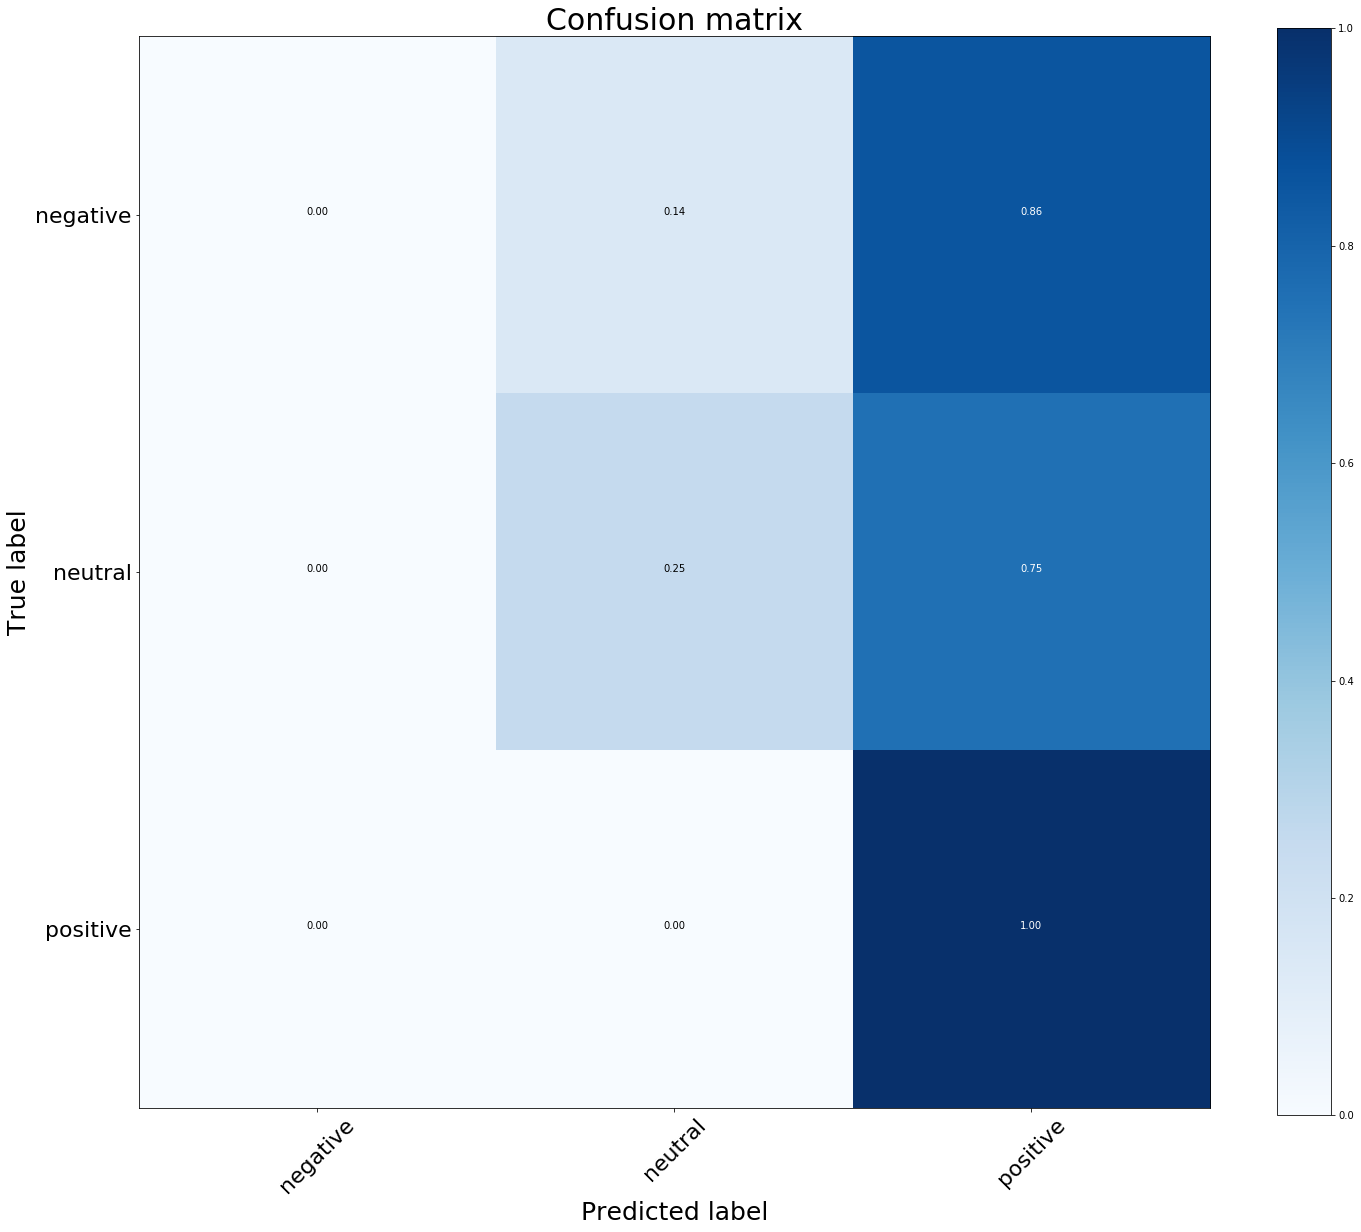

In [44]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()